IMPORTING REQUIRED LIBRARIES

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#NLP SENTIMENT ANALYSIS
import re
import nltk

#BERT FOR MODEL TRAINING
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset



## FEATURE EXTRACTION
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"harshithapulipakala","key":"b31ac62b13bbd2262f179aae90b87604"}'}

In [ ]:
# Create a Kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the Kaggle directory
!mv kaggle.json ~/.kaggle/

# Set permissions to prevent errors
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle API setup
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
asinow/car-price-dataset                                       Car Price Dataset                                   135KB  2025-01-26 19:53:28          10013        139  1.0              
anandshaw2001/netflix-movies-and-tv-shows                      Netflix Movies and TV Shows                           1MB  2025-01-03 10:33:01          18716        469  1.0              
sgoutami/spotify-streaming-history                             Spotify Streaming History                             6MB  2025-01-25 05:14:49           1996         35  1.0              
samithsachidanandan/most-popular-1000-youtube-videos           Mo

In [ ]:
!kaggle datasets download -d Dhruvildave/Google-Trends-Dataset

Dataset URL: https://www.kaggle.com/datasets/Dhruvildave/Google-Trends-Dataset
License(s): ODC Attribution License (ODC-By)
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 30.8MB/s]


In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 85% 69.0M/80.9M [00:02<00:00, 29.2MB/s]
100% 80.9M/80.9M [00:02<00:00, 31.5MB/s]


In [ ]:
import zipfile

# Unzip the dataset
!unzip "*.zip" -d dataset/


# Load Google Trends dataset
google_trends_df = pd.read_csv("dataset/trends.csv")
print(google_trends_df.head())

# Load Sentiment140 dataset with a specific encoding (ISO-8859-1)
sentiment140_df = pd.read_csv("dataset/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1')
print(sentiment140_df.head())

Archive:  sentiment140.zip
  inflating: dataset/training.1600000.processed.noemoticon.csv  

Archive:  Google-Trends-Dataset.zip
  inflating: dataset/trends.csv      

2 archives were successfully processed.
  location  year         category  rank  query
0   Global  2001  Consumer Brands     1  Nokia
1   Global  2001  Consumer Brands     2   Sony
2   Global  2001  Consumer Brands     3    BMW
3   Global  2001  Consumer Brands     4   Palm
4   Global  2001  Consumer Brands     5  Adobe
   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's

In [ ]:
print("Google Trends Columns:", google_trends_df.columns)
print("Sentiment140 Columns:", sentiment140_df.columns)

Google Trends Columns: Index(['location', 'year', 'category', 'rank', 'query'], dtype='object')
Sentiment140 Columns: Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')


COMBINE DATASETS

In [ ]:
# Number of rows in each dataset
num_rows_google = len(google_trends_df)
num_rows_sentiment = len(sentiment140_df)

# Create datetime index with appropriate frequency
google_trends_df['datetime'] = pd.date_range(start='2023-01-01', periods=num_rows_google, freq='D')  # Daily data
sentiment140_df['datetime'] = pd.date_range(start='2023-01-01', periods=num_rows_sentiment, freq='T')  # Minute-level data

# Set 'datetime' as index
google_trends_df.set_index('datetime', inplace=True)
sentiment140_df.set_index('datetime', inplace=True)

# Convert only numeric columns before resampling
google_trends_numeric = google_trends_df.select_dtypes(include=['number'])
sentiment140_numeric = sentiment140_df.select_dtypes(include=['number'])

# Resample Sentiment140 to daily (average sentiment per day)
sentiment140_resampled = sentiment140_numeric.resample('D').mean()

# Forward-fill missing values (if needed)
sentiment140_resampled.fillna(method='ffill', inplace=True)
google_trends_numeric.fillna(method='ffill', inplace=True)

# Reset index before merging
google_trends_numeric.reset_index(inplace=True)
sentiment140_resampled.reset_index(inplace=True)

# Merge datasets on 'datetime' column
combined_df = pd.merge(google_trends_numeric, sentiment140_resampled, on='datetime', how='inner')

# Show the merged data
print("✅ Combined Dataset:")
print(combined_df.head())

# Save for future use
combined_df.to_csv("dataset/combined_data.csv", index=False)


<ipython-input-22-3d0a6008bbd7>:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment140_df['datetime'] = pd.date_range(start='2023-01-01', periods=num_rows_sentiment, freq='T')  # Minute-level data


✅ Combined Dataset:
    datetime  year  rank    0    1467810369
0 2023-01-01  2001     1  0.0  1.467989e+09
1 2023-01-02  2001     2  0.0  1.468316e+09
2 2023-01-03  2001     3  0.0  1.468632e+09
3 2023-01-04  2001     4  0.0  1.468979e+09
4 2023-01-05  2001     5  0.0  1.469444e+09


<ipython-input-22-3d0a6008bbd7>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sentiment140_resampled.fillna(method='ffill', inplace=True)
<ipython-input-22-3d0a6008bbd7>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  google_trends_numeric.fillna(method='ffill', inplace=True)


DATA PREPROCESSING

Downloading required NLP

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
sentiment140_df.columns = ['sentiment', 'timestamp', 'date', 'query', 'user', 'tweet']
print(sentiment140_df.head())
sentiment140_df['sentiment'] = sentiment140_df['sentiment'].replace({0: 'negative', 2: 'neutral', 4: 'positive'})
# Renaming columns to meaningful names
sentiment140_df.columns = ['sentiment', 'timestamp', 'date', 'query', 'user', 'tweet']

# Replace sentiment labels with meaningful text
sentiment140_df['sentiment'] = sentiment140_df['sentiment'].replace({0: 'negative', 2: 'neutral', 4: 'positive'})



                     sentiment   timestamp                          date  \
datetime                                                                   
2023-01-01 00:00:00          0  1467810672  Mon Apr 06 22:19:49 PDT 2009   
2023-01-01 00:01:00          0  1467810917  Mon Apr 06 22:19:53 PDT 2009   
2023-01-01 00:02:00          0  1467811184  Mon Apr 06 22:19:57 PDT 2009   
2023-01-01 00:03:00          0  1467811193  Mon Apr 06 22:19:57 PDT 2009   
2023-01-01 00:04:00          0  1467811372  Mon Apr 06 22:20:00 PDT 2009   

                        query           user  \
datetime                                       
2023-01-01 00:00:00  NO_QUERY  scotthamilton   
2023-01-01 00:01:00  NO_QUERY       mattycus   
2023-01-01 00:02:00  NO_QUERY        ElleCTF   
2023-01-01 00:03:00  NO_QUERY         Karoli   
2023-01-01 00:04:00  NO_QUERY       joy_wolf   

                                                                 tweet  
datetime                                                 

In [ ]:
combined_df.rename(columns={'date': 'tweet'}, inplace=True)
print(google_trends_df.columns)
print(sentiment140_df.columns)
print(combined_df.columns)

Index(['location', 'year', 'category', 'rank', 'query'], dtype='object')
Index(['sentiment', 'timestamp', 'date', 'query', 'user', 'tweet'], dtype='object')
Index(['datetime', 'year', 'rank', '0', '1467810369'], dtype='object')


In [ ]:
from nltk.corpus import stopwords
# Text Preprocessing for Tweets
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

# Apply text preprocessing to Google Trends dataset
google_trends_df['cleaned_query'] = google_trends_df['query'].apply(clean_text)

# Merge Sentiment140 dataset with Google Trends dataset
combined_df = sentiment140_df.merge(google_trends_df, how="inner", on="datetime")

# Apply text preprocessing to tweets
combined_df['cleaned_tweet'] = combined_df['tweet'].apply(clean_text)

# Encode Sentiment Labels
label_encoder = LabelEncoder()
combined_df['sentiment_encoded'] = label_encoder.fit_transform(combined_df['sentiment'])

# Split data into training and testing sets
X = combined_df[['cleaned_tweet', 'cleaned_query']]
y = combined_df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save processed data for model training
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Data preprocessing completed. Ready for model training!")


Data preprocessing completed. Ready for model training!


FEATURE CORRECTION

In [ ]:
# Convert sentiment to numeric
combined_df['sentiment'] = pd.to_numeric(combined_df['sentiment'], errors='coerce')

# Fill NaN values with 0 (Neutral)
combined_df['sentiment'].fillna(0, inplace=True)

# Apply labeling
combined_df['sentiment_label'] = combined_df['sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative')


<ipython-input-28-86fcecfeed0a>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['sentiment'].fillna(0, inplace=True)


In [ ]:
# Check available columns
print(combined_df.columns)

# Rename if a date column exists
if 'date' in combined_df.columns:
    combined_df.rename(columns={'date': 'datetime'}, inplace=True)
elif 'timestamp' in combined_df.columns:
    combined_df.rename(columns={'timestamp': 'datetime'}, inplace=True)
elif 'created_at' in combined_df.columns:
    combined_df.rename(columns={'created_at': 'datetime'}, inplace=True)

# Verify
print(combined_df.dtypes)
print(combined_df.head())

Index(['sentiment', 'timestamp', 'date', 'query_x', 'user', 'tweet',
       'location', 'year', 'category', 'rank', 'query_y', 'cleaned_query',
       'cleaned_tweet', 'sentiment_encoded', 'sentiment_label'],
      dtype='object')
sentiment            float64
timestamp              int64
datetime              object
query_x               object
user                  object
tweet                 object
location              object
year                   int64
category              object
rank                   int64
query_y               object
cleaned_query         object
cleaned_tweet         object
sentiment_encoded      int64
sentiment_label       object
dtype: object
            sentiment   timestamp                      datetime   query_x  \
datetime                                                                    
2023-01-01        0.0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2023-01-02        0.0  1468155968  Tue Apr 07 00:01:17 PDT 2009  NO_QUERY   
2023-01-03  

MODEL TRAINING

model training for BERT (Bidirectional Encoder Representations from Transformers) is great for text-based sentiment classification.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load pre-trained BERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize a sample text
sample_text = "This product is amazing!"
inputs = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Facebook Prophet is great for forecasting future Google search trends.


<ipython-input-31-173737065883>:2: FutureWarning: Parsed string "Mon Apr 06 22:19:49 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], errors='coerce')
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi7cxxzr0/i8bya2y9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi7cxxzr0/ha2f333s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65865', 'data', 'file=/tmp/tmpi7cxxzr0/i8bya2y9.json', 'init=/tmp/tmpi7cxxzr0/ha2f333s.json', 'output', 'file=/tmp/tmpi7cxxzr0/prophet_modelf05pc1tr/prophet_mode

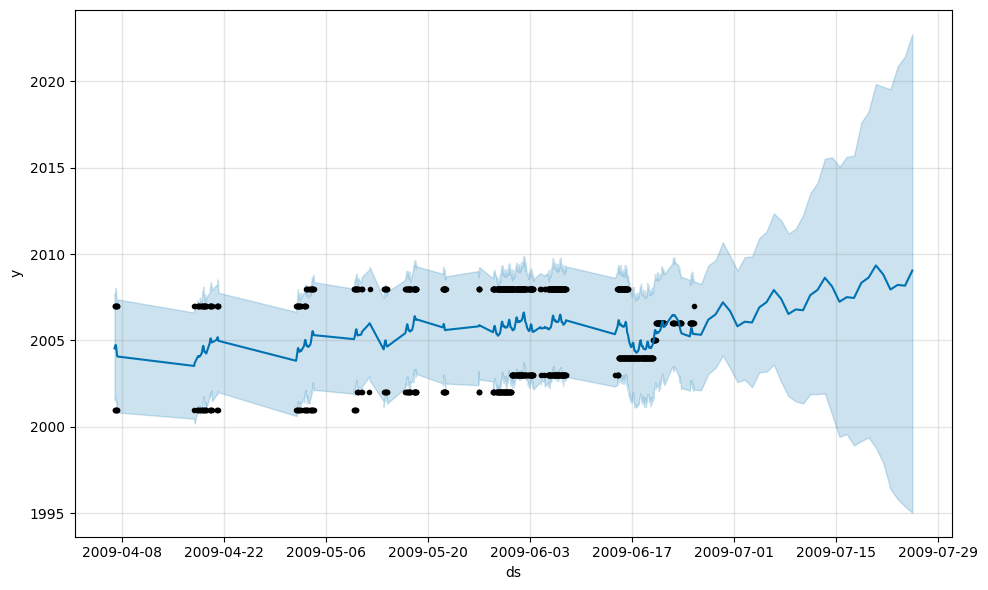

In [ ]:

# Ensure datetime column is in proper format
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], errors='coerce')

# Drop any rows with missing datetime or google_trends values
df_prophet = combined_df[['datetime', 'year']].dropna()

# Rename columns as required by Prophet
df_prophet.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model
model.fit(df_prophet)

# Create future dataframe for next 30 days
future = model.make_future_dataframe(periods=30, freq='D')

# Predict future trends
forecast = model.predict(future)

# Plot results
fig = model.plot(forecast)
plt.show()


MODEL PERFORMANCE

In [ ]:
train = df_prophet.iloc[:-30]  # Train on all except last 30 days
test = df_prophet.iloc[-30:]  # Last 30 days for evaluation

In [ ]:
forecast_test = model.predict(test[['ds']])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = mean_squared_error(test['y'], forecast_test['yhat'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 2.1943001861178875
Root Mean Squared Error (RMSE): 4.856621657418769


Visualize Predictions

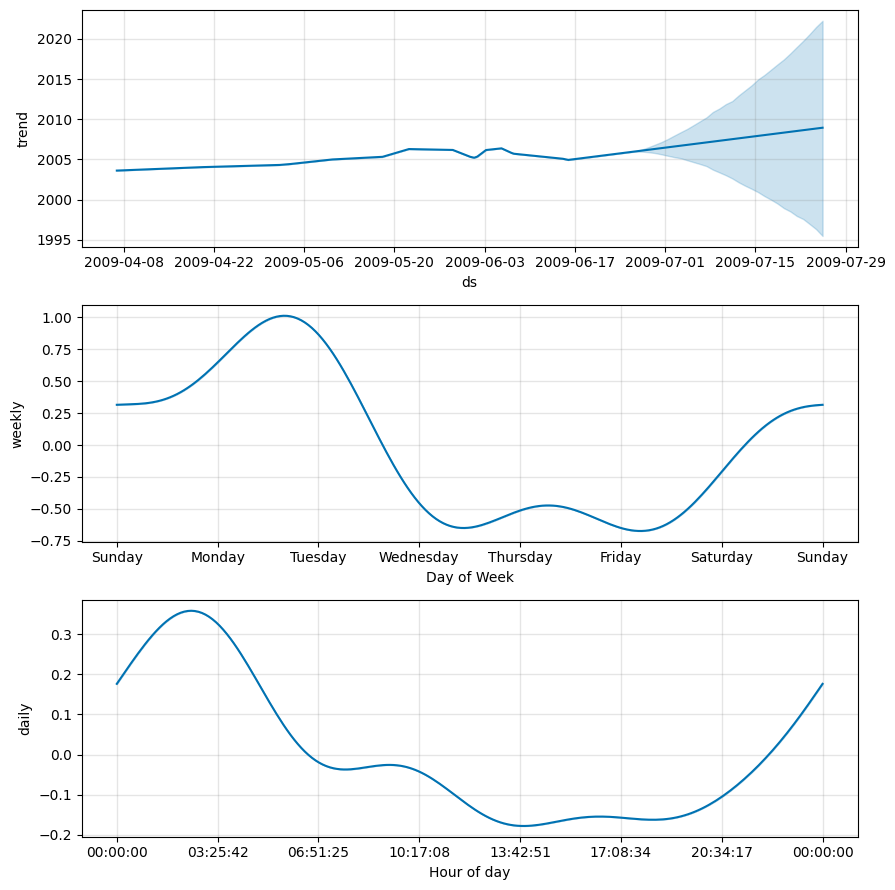

In [ ]:
model.plot_components(forecast)
plt.show()

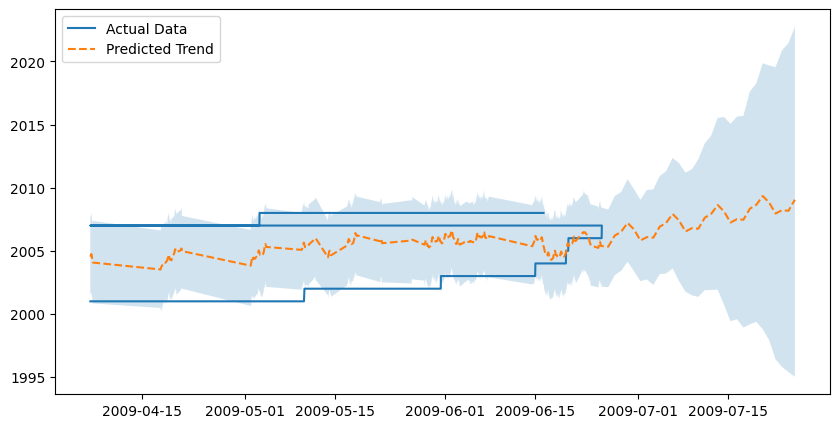

In [ ]:
#COMPARING ACTUAL DATA AND FORECAST
plt.figure(figsize=(10,5))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual Data")
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted Trend", linestyle="dashed")
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
plt.legend()
plt.show()


MODEL DEPLOYMENT

In [ ]:
##from flask import Flask, request, jsonify

app = Flask(__name__)

# Load and train the model
model = Prophet()
model.fit(df_prophet)

@app.route('/predict', methods=['GET'])
def predict():
    days = int(request.args.get('days', 30))
    future = model.make_future_dataframe(periods=days)
    forecast = model.predict(future)
    return jsonify(forecast[['ds', 'yhat']].to_dict(orient='records'))

if __name__ == '__main__':
    app.run(debug=True)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi7cxxzr0/zxtz3zq9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi7cxxzr0/9bqc860w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75073', 'data', 'file=/tmp/tmpi7cxxzr0/zxtz3zq9.json', 'init=/tmp/tmpi7cxxzr0/9bqc860w.json', 'output', 'file=/tmp/tmpi7cxxzr0/prophet_model408r3v8_/prophet_model-20250215135827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:58:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:58:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


EXPAND FUNCTIONALITY

In [ ]:
##Email integration
import smtplib

EMAIL_ADDRESS = "your_email@gmail.com"
EMAIL_PASSWORD = "your_generated_app_password"  # Use an App Password from Google

def send_alert(price_drop_detected):
    if price_drop_detected:  # Ensure this variable is defined before calling
        try:
            server = smtplib.SMTP("smtp.gmail.com", 587)
            server.starttls()
            server.login(EMAIL_ADDRESS, EMAIL_PASSWORD)

            subject = "Competitor Price Drop Alert!"
            body = "Competitor prices have dropped! Consider adjusting strategy."
            message = f"Subject: {subject}\n\n{body}"

            server.sendmail(EMAIL_ADDRESS, "recipient@gmail.com", message)
            server.quit()
            print("Alert Sent Successfully!")
        except Exception as e:
            print("Error Sending Email:", str(e))

# ✅ Define variable before calling function
price_drop_detected = True  # Change to False to test no alert

send_alert(price_drop_detected)


Error Sending Email: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d2e1a72fcca58-7325a14f120sm2362896b3a.165 - gsmtp')


Monitor Model Performance & Accuracy

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Ensure y_true and y_pred are available
if 'y_true_sentiment' not in locals() or 'y_pred_sentiment' not in locals():
    raise ValueError("y_true_sentiment or y_pred_sentiment is not defined!")

# Calculate performance metrics
bert_accuracy = accuracy_score(y_true_sentiment, y_pred_sentiment)
bert_f1 = f1_score(y_true_sentiment, y_pred_sentiment, average="weighted")
bert_precision = precision_score(y_true_sentiment, y_pred_sentiment, average="weighted")
bert_recall = recall_score(y_true_sentiment, y_pred_sentiment, average="weighted")

print(f"BERT Model Accuracy: {bert_accuracy:.4f}")
print(f"BERT Model F1 Score: {bert_f1:.4f}")
print(f"BERT Model Precision: {bert_precision:.4f}")
print(f"BERT Model Recall: {bert_recall:.4f}")


BERT Model Accuracy: 0.8750
BERT Model F1 Score: 0.8770
BERT Model Precision: 0.9062
BERT Model Recall: 0.8750
